# L3: Image generation app 🎨

Load your HF API key and relevant Python libraries

In [8]:
import os
import io
import IPython.display
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [12]:
# Helper function
import requests, json

#Text-to-image endpoint
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    
    if response.headers['Content-Type'] == 'application/json':
        # Handle JSON response
        return json.loads(response.content.decode("utf-8"))
    elif 'image' in response.headers['Content-Type']:
        # Handle image (binary data) response
        return base64.b64encode(response.content).decode()
    else:
        # Handle other content types or raise an error
        raise ValueError("Unsupported response content type")

## Building an image generation app 

Here we are going to run `runwayml/stable-diffusion-v1-5` using the `🧨 diffusers` library.


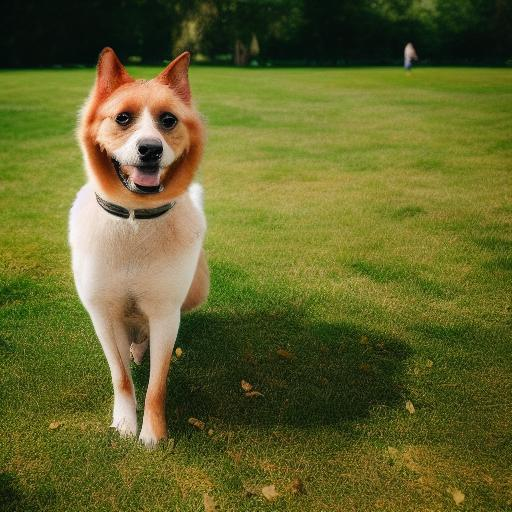

In [14]:
prompt = "a dog in a park"

result = get_completion(prompt)
IPython.display.HTML(f'<img src="data:image/png;base64,{result}" />')

## Generating with `gr.Interface()`

In [15]:
import gradio as gr 

#A helper function to convert the PIL image to base64
#so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Your prompt")],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never",
                    examples=["the spirit of a tamagotchi wandering in the city of Vienna","a mecha robot in a favela"])

demo.launch(share=True, server_port=int(os.environ['PORT1']))

Running on local URL:  http://127.0.0.1:3010
Running on public URL: https://c2555b7949c05ea319.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [16]:
demo.close()

Closing server running on port: 3010


## Building a more advanced interface

In [23]:
import gradio as gr 

#A helper function to convert the PIL image to base64 
# so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }
    
    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

#### gr.Slider()
- You can set the `minimum`, `maximum`, and starting `value` for a `gr.Slider()`.
- If you want the slider to increment by integer values, you can set `step=1`.

In [27]:
gr.close_all()

# a dog playing on a park, anime style
# low quality

demo = gr.Interface(fn=generate,
                    inputs=[
                        gr.Textbox(label="Your prompt"),
                        gr.Textbox(label="Negative prompt"),
                        gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                                 info="In how many steps will the denoiser denoise the image?"),
                        gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7, 
                                  info="Controls how much the text prompt influences the result"),
                        gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512),
                        gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512),
                    ],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never"
                    )

demo.launch(share=True, server_port=int(os.environ['PORT2']))

Closing server running on port: 3010
Closing server running on port: 3020
Closing server running on port: 3020
Running on local URL:  http://127.0.0.1:3020
Running on public URL: https://0371359891506d0118.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [28]:
demo.close()

Closing server running on port: 3020


## `gr.Blocks()`

- Within `gr.Blocks()`, you can define multiple `gr.Row()`s, or multiple `gr.Column()`s.
- Note that if the jupyter notebook is very narrow, the layout may change to better display the objects.  If you define two columns but don't see the two columns in the app, try expanding the width of your web browser, and the screen containing this jupyter notebook.

- When using `gr.Blocks()`, you'll need to explicitly define the "Submit" button using `gr.Button()`, whereas the 'Clear' and 'Submit' buttons are automatically added when using `gr.Interface()`.

In [29]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    prompt = gr.Textbox(label="Your prompt")
    with gr.Row():
        with gr.Column():
            negative_prompt = gr.Textbox(label="Negative prompt")
            steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
            guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
            width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
            height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
            btn = gr.Button("Submit")
        with gr.Column():
            output = gr.Image(label="Result")

    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

Closing server running on port: 3010
Closing server running on port: 3020
Closing server running on port: 3020
Closing server running on port: 3020
Running on local URL:  http://127.0.0.1:3030
Running on public URL: https://43652706e7c76f4710.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [30]:
demo.close()

Closing server running on port: 3030


#### scale

- To choose how much relative width to give to each column, set the `scale` parameter of each `gr.Column()`.  
- If one column has `scale=4` and the second column has `scale=1`, then the first column takes up 4/5 of the total width, and the second column takes up 1/5 of the total width.

#### gr.Accordion()
- The `gr.Accordion()` can show/hide  the app options with a mouse click.
- Set `open=True` to show the contents of the Accordion by default, or `False` to hide it by default.

In [31]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="Your prompt") #Give prompt some real estate
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("Submit") #Submit button side by side!
    with gr.Accordion("Advanced options", open=False): #Let's hide the advanced options!
            negative_prompt = gr.Textbox(label="Negative prompt")
            with gr.Row():
                with gr.Column():
                    steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
                    guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
                with gr.Column():
                    width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
                    height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="Result") #Move the output up too
            
    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT4']))

Closing server running on port: 3010
Closing server running on port: 3020
Closing server running on port: 3020
Closing server running on port: 3020
Running on local URL:  http://127.0.0.1:3040
Running on public URL: https://8ed0d53ea4b330e041.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [33]:
gr.close_all()

Closing server running on port: 3010
Closing server running on port: 3020
Closing server running on port: 3020
Closing server running on port: 3020
